##### Copyright 2022 The TensorFlow Probability Authors

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Adaptive MALT

## Install Dependencies

In [0]:
!rm -Rf probability
!rm -Rf fun_mc
!rm -Rf inference_gym
!git clone --depth 1 https://github.com/tensorflow/probability.git
!mv probability/spinoffs/fun_mc/fun_mc .
!mv probability/spinoffs/inference_gym/inference_gym .
!mv probability/discussion .
!pip install -U tfp-nightly jax jaxlib immutabledict gin etils h5py

Cloning into 'probability'...
remote: Enumerating objects: 1486, done.
remote: Counting objects: 100% (1486/1486), done.
remote: Compressing objects: 100% (1276/1276), done.
remote: Total 1486 (delta 373), reused 727 (delta 202), pack-reused 0
Receiving objects: 100% (1486/1486), 39.43 MiB | 12.87 MiB/s, done.
Resolving deltas: 100% (373/373), done.
mv: cannot move 'probability/discussion' to './discussion': Directory not empty
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gin: filename=gin-0.1.6-py3-none-any.whl size=3379 sha256=0b89735dd105e8279d301824687533bb1d34952b9aeec75bdfb35e000a3a1fe3
  Stored in directory: /root/.cache/pip/wheels/5e/a8/6b/f057bdbc4292a581451eaa3c67f5515f2e415111763af159ca
Successfully built gin


# Imports

In [0]:
import gin
gin.enter_interactive_mode()

import contextlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
from typing import Any
import jax
import jax.numpy as jnp

import tensorflow_probability.substrates.jax as tfp
import tensorflow_probability.substrates.numpy as tfp_np
from inference_gym import using_jax as gym
from discussion.adaptive_malt import adaptive_malt
import fun_mc.using_jax as fun_mc

tfd = tfp.distributions
tfed = tfp.experimental.distributions
tfb = tfp.bijectors

sb.set_style(style='white')

# Utilities

In [0]:
def randseed(seed=None, do_print=True):
  if seed is None:
    seed = np.random.randint(2**32)
    if do_print:
      print('seed:', seed)
    seed = jax.random.PRNGKey(seed)
  elif isinstance(seed, int):
    seed = jax.random.PRNGKey(seed)
  return seed

def exp_mean(vals, window_size=None, f=4):
  vals = jnp.asarray(vals)

  def kernel(rm_state, i):
    if window_size is None:
      cur_window_size = jnp.maximum(1, i // f)
    else:
      cur_window_size = window_size
    rm_state, _ = fun_mc.running_mean_step(
        rm_state, vals[i], window_size=cur_window_size)
    return (rm_state, i + 1), rm_state.mean

  _, exp_mean = fun_mc.trace(
      (fun_mc.running_mean_init(vals.shape[1:], jnp.float32), 0), kernel,
      vals.shape[0])
  return exp_mean

# Experiment

In [0]:
target = adaptive_malt.get_target('test_gaussian_1')

In [0]:
num_adaptation_steps = 10000

In [0]:
@jax.jit
def run(seed):

  return adaptive_malt.run_adaptive_mcmc_on_target(
      target=target,
      method='malt',
      num_chains=1,
      init_step_size=1e-2,
      trajectory_length_adaptation_rate=0.01,
      trajectory_length_adaptation_rate_decay='linear',
      step_size_adaptation_rate_decay='linear',
      seed=seed,
      num_adaptation_steps=num_adaptation_steps,
      num_results=10000,
      vector_step_size=jnp.ones(target.event_shape),
      adapt_normalization_power=True,
      target_accept_prob=0.7,
      rvar_factor=8,
      principal_factor=3,
      rvar_smoothing=1,
      use_precond_eigenvalue=True,
      trajectory_opt_kwargs={'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8},
  )

In [0]:
trace, final = run(randseed())

seed: 3030568139


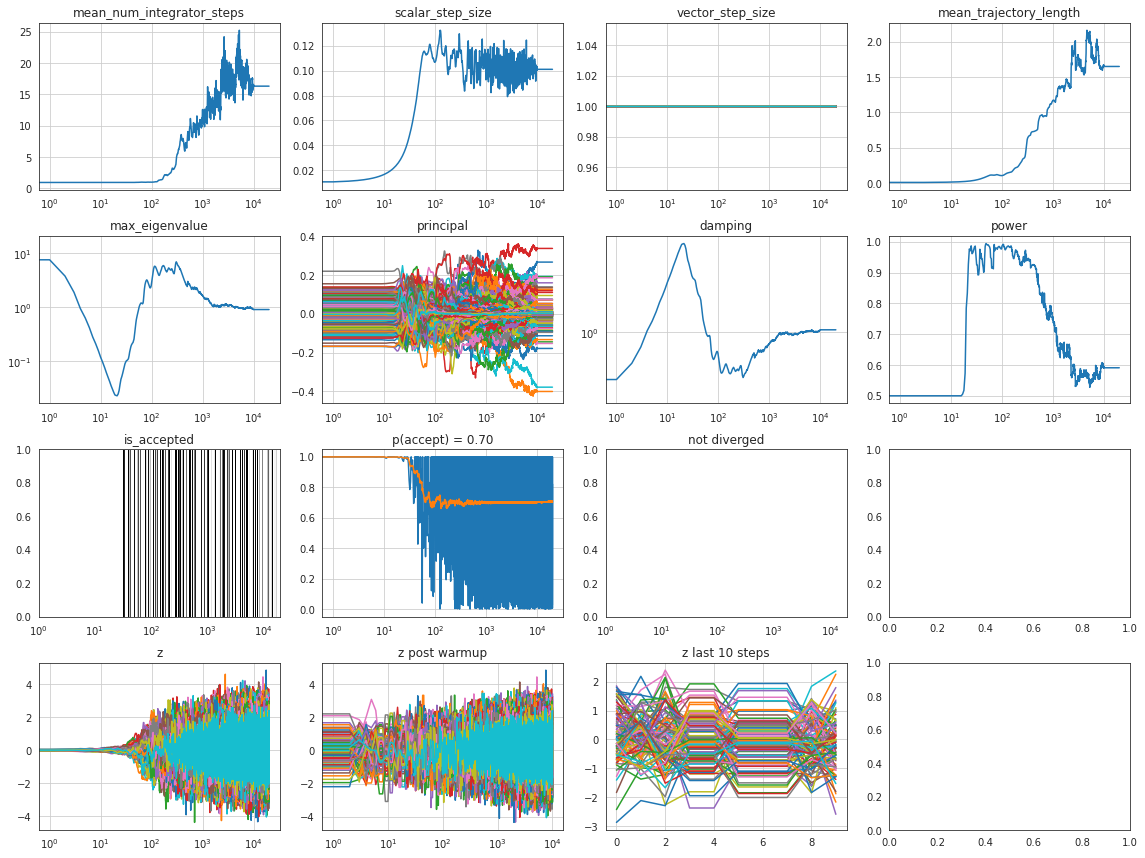

In [0]:
fig, axs = plt.subplots(4, 4, figsize=(16, 12))

ax = axs[0, 0]
ax.set_title('mean_num_integrator_steps')
ax.plot(trace['mean_trajectory_length'] / trace['scalar_step_size'])
ax.set_xscale('log')
ax.grid(True)

ax = axs[0, 1]
ax.set_title('scalar_step_size')
ax.plot(trace['scalar_step_size'])
ax.set_xscale('log')
ax.grid(True)

ax = axs[0, 2]
ax.set_title('vector_step_size')
ax.plot(trace['vector_step_size'])
ax.set_xscale('log')
ax.grid(True)

ax = axs[0, 3]
ax.set_title('mean_trajectory_length')
ax.plot(trace['mean_trajectory_length'])
ax.set_xscale('log')
ax.grid(True)

ax = axs[1, 0]
ax.set_title('max_eigenvalue')
ax.plot(trace['max_eigenvalue'])
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(True)

ax = axs[1, 1]
ax.set_title('principal')
ax.plot(trace['principal'])
ax.set_xscale('log')
ax.grid(True)

if trace['damping'] is not None:
  ax = axs[1, 2]
  ax.set_title('damping')
  ax.plot(trace['damping'])
  ax.set_yscale('log')
  ax.set_xscale('log')
  ax.grid(True)

ax = axs[1, 3]
ax.set_title('power')
ax.plot(trace['power'])
ax.set_xscale('log')
ax.grid(True)

ax = axs[2, 0]
ax.set_title('is_accepted')
ax.imshow(
    trace['is_accepted'][1:].T,
    cmap='gray',
    interpolation='antialiased',
    vmin=0,
    vmax=1,
    extent=[1, len(trace['state']), 0, trace['state'].shape[1]])
ax.set_xscale('log')
ax.set_aspect('auto')

ax = axs[2, 1]
p_accept = jnp.exp(jnp.minimum(0., trace['log_accept_ratio'])).mean(-1)
ax.set_title(f'p(accept) = {p_accept.mean():.2f}')
ax.plot(p_accept)
ax.plot(exp_mean(p_accept))
ax.set_aspect('auto')
ax.set_xscale('log')
ax.grid(True)

ax = axs[2, 2]
ax.set_title('not diverged')
ax.imshow(
    (jnp.abs(trace['log_accept_ratio']) < 500.)[1:].T,
    cmap='gray',
    interpolation='antialiased',
    vmin=0,
    vmax=1,
    extent=[1, len(trace['state']), 0, trace['state'].shape[1]])
ax.set_xscale('log')
ax.set_aspect('auto')

ax = axs[3, 0]
ax.set_title('z')
ax.plot(trace['state'][:, 0, :100])
ax.set_xscale('log')
ax.grid(True)

ax = axs[3, 1]
ax.set_title('z post warmup')
ax.plot(trace['state'][num_adaptation_steps:, 0, :100])
ax.set_xscale('log')
ax.grid(True)

ax = axs[3, 2]
ax.set_title('z last 10 steps')
ax.plot(trace['state'][-10:, 0, :100])
ax.grid(True)

fig.tight_layout()

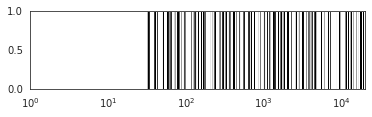

In [0]:
plt.imshow(
    trace['is_accepted'].T,
    cmap='gray',
    interpolation='antialiased',
    vmin=0,
    vmax=1,
    extent=[1, 20000, 0, 1])
plt.xscale('log')

In [0]:
for name, stats in final['stats'].items():
  print(name)
  print('min ess_per_grad', stats['ess_per_grad'].min())
  print('max rhat', stats['rhat'].max())
  print()

m1
min ess_per_grad 0.011451964
max rhat 1.0107002

m2
min ess_per_grad 0.018432274
max rhat 1.0045991

norm_sq
min ess_per_grad 0.018432274
max rhat 1.0045991

p_m2
min ess_per_grad 0.017687207
max rhat 1.0007386

